# Intro to Variational Auto Encoder

<a href="https://colab.research.google.com/github/hbretonniere/ucsc_ml_intro/blob/master/tensorflow/VAE_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers
from tqdm import trange
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tensorflow.python import debug as tf_debug
tfd = tfp.distributions
tf.keras.backend.clear_session()  # For easy reset of notebook state.


# Check tf and tensorflow proba versions

In [10]:
tf.__version__

'2.11.0'

In [11]:

tfp.__version__

'0.18.0'

## Encoder

We create a simple Encoder, but with a simple change from the AE's one: we don't output a vector of `latend_dim` dimension, but of `2*latent_dim`: the means and sigmas of the multivariate distribution that we will create in the decoder.

In [13]:
def encoder(latent_dim):

    encoder_input = tfk.Input(shape=(28, 28, 1))

    x = layers.Conv2D(8, (3,3), 2, 'SAME', activation='relu')(encoder_input)
    x = layers.Conv2D(16, (3,3), 2, 'SAME', activation='relu')(x)
    # x = layers.Conv2D(64, (3,3), 2, 'SAME', activation='relu')(x)
    x = layers.Flatten()(x)
    # x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(2*latent_dim)(x)

    encoder_output = x
    Encoder = tfk.Model(encoder_input, encoder_output, name='encoder_VAE_MNIST')
    return Encoder, encoder_output


## Choose the latent dimension of the VAE. 
Powers of two are better !

In [14]:
latent_dim = 8

In [15]:
Encoder, encoder_output = encoder(latent_dim)
Encoder.summary()

Model: "encoder_VAE_MNIST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 16)          1168      
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 16)                12560     
                                                                 
Total params: 13,808
Trainable params: 13,808
Non-trainable params: 0
_________________________________________________________________


2024-04-22 16:15:44.992233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Decoder

Here we create the decoder for the VAE. We have to add the creation of the distribution and the sample.
to do so, we use the super powerful TensorFlow Probability package.
Doing so, we can create a tfp distribution, where we pass the mus and sigmas as argument. check the tfp.layers.DistributionLambda doc for more info.
We also use the reparameterization trick (check on the web, there is a lot of good blog post explaining what it is and why we need it, e.g. https://stats.stackexchange.com/questions/199605/how-does-the-reparameterization-trick-for-vaes-work-and-why-is-it-important).



In [17]:
def decoder(encoder_output, latent_dim):

    decoder_input = tfk.Input(shape=encoder_output.shape[1:]) #ignore batch size
    x = tfp.layers.DistributionLambda(make_distribution_fn=lambda t:\
             tfd.MultivariateNormalDiag(loc=t[..., :latent_dim], scale_diag=tf.exp(t[..., latent_dim:])),
             convert_to_tensor_fn=lambda s: s.sample())(decoder_input)

    z_mean = decoder_input[..., :latent_dim]
    z_log_var = decoder_input[..., latent_dim:]
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # reparameterization trick
    
    # this is the sample of the atent space, the rest is a simple decoder as we did for the AE.
    x = z_mean + tf.exp(0.5 * z_log_var) * epsilon


    x = layers.Dense(7 * 7 * 64, activation='relu')(x)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(16, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2D(1, 3, activation='sigmoid', strides=1, padding='same')(x)
#     out_2 = layers.Conv2D(1, 3, activation='sigmoid', strides=1, padding='same')(x)
    decoder_output = x
    Decoder = tfk.Model(inputs=decoder_input, outputs=x, name='decoder_VAE_MNIST')
    return Decoder

In [19]:
Decoder = decoder(encoder_output, latent_dim)


# VAE model
We can know wrap the encoder and decoder into a global keras model:

In [20]:
VAE_input = tfk.Input(shape=(28, 28, 1))

encoded_distrib_params = Encoder(VAE_input)

decoded_img = Decoder(encoded_distrib_params)

VAE_output = [decoded_img, encoded_distrib_params]

model = tfk.Model(inputs=VAE_input, outputs=VAE_output, name='mnist_vae')
model.summary()

Model: "mnist_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder_VAE_MNIST (Function  (None, 16)               13808     
 al)                                                             
                                                                 
 decoder_VAE_MNIST (Function  (None, 28, 28, 1)        51457     
 al)                                                             
                                                                 
Total params: 65,265
Trainable params: 65,265
Non-trainable params: 0
_________________________________________________________________


## Load the MNIST dataset

In [24]:
(x_train, y_train), (x_test, y_test) = tfk.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(128)


## Loss

Our loss is a reconstruction loss (classic AE loss) and the KL. Using Gaussian as priors, the KL has a very simple expression.
Check the computation on internet to see how we get this expression.
We use a beta=1, i.e. a equal weight for the rec and kl loss.

In [27]:
def loss_fn(y_true, y_predict, beta=1):
    
    reconstruct = y_predict[0]
    rec_loss_batch = tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, reconstruct), axis=[1, 2])
    rec_loss = tf.reduce_mean(rec_loss_batch)

    z_mean, z_sigma = y_predict[1][:, :latent_dim], y_predict[1][:, latent_dim:]
    kl_loss_batch = -0.5 * tf.reduce_sum(z_sigma - tf.square(z_mean) - tf.exp(z_sigma) + 1, axis=1)
    kl_loss = tf.reduce_mean(kl_loss_batch)
    loss = rec_loss + beta*kl_loss

    return loss, rec_loss, kl_loss




### optimizers

In [28]:
optimizer = tfk.optimizers.Adam(learning_rate=0.005)

## Custom train function

In [29]:
@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        prediction = model(x)
        tot_loss, rec_loss, kl_loss = loss_fn(x, prediction)

        grads = tape.gradient(tot_loss, model.trainable_variables)

    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return tot_loss, rec_loss, kl_loss

## Training Loop

On a cpu, it can take up to 10 minutes

In [31]:
nb_epochs = 20

test_train = []
tot_loss_results = []
rec_loss_results = []
kl_loss_results = []

t = trange(nb_epochs, desc='Convo VAE')


''' Training Loop'''
for epoch in t:
    epoch_loss_avg = tf.keras.metrics.Mean()
    for i, features in enumerate(x_train):
        losses = train_step(features)
        tot_loss_results.append(losses[0])
        rec_loss_results.append(losses[1])
        kl_loss_results.append(losses[2])

    t.set_description('Conv VAE, loss=%g' % tot_loss_results[-1])


Conv VAE, loss=112.167: 100%|██████████| 20/20 [10:56<00:00, 32.81s/it]


[Text(0.5, 0, 'Step'), Text(0.5, 0, 'Step'), Text(0.5, 0, 'Step')]

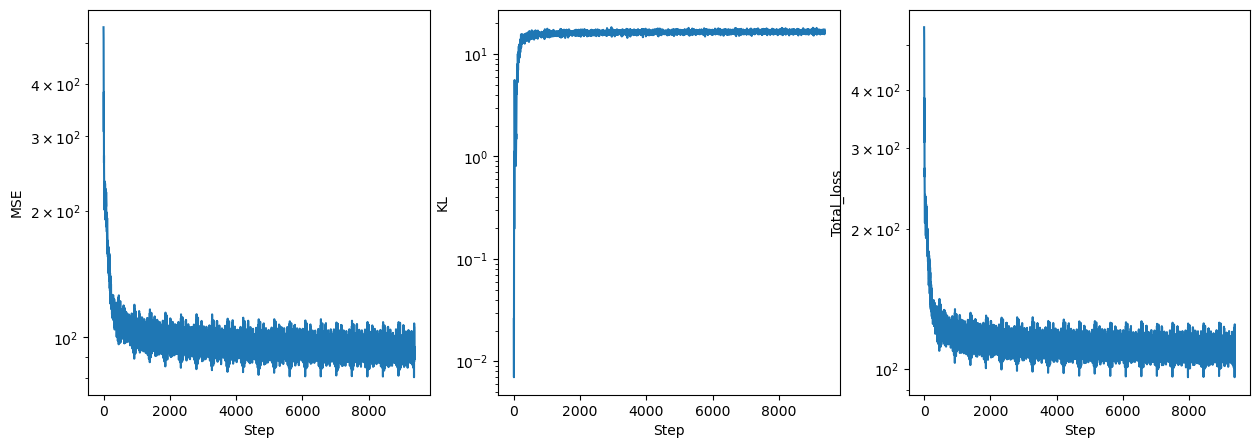

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(np.arange(len(rec_loss_results)), rec_loss_results)
ax[1].plot(np.arange(len(kl_loss_results)), kl_loss_results)
ax[2].plot(np.arange(len(tot_loss_results)), tot_loss_results)

[ax[i].set_yscale('log') for i in range(3)]

ax[0].set_ylabel('MSE')
ax[1].set_ylabel('KL')
ax[2].set_ylabel('Total_loss')

[ax[i].set_xlabel('Step') for i in range(3)]

## Plot some reconstruction

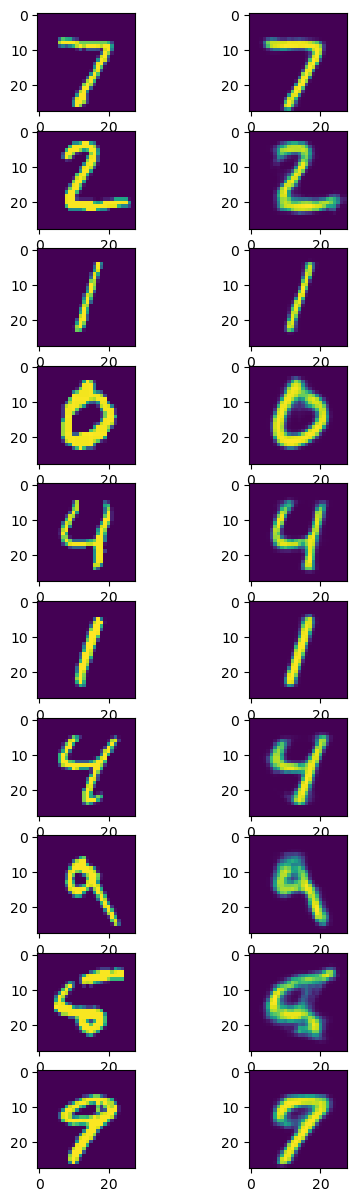

In [35]:
fig, ax = plt.subplots(10, 2, figsize=(5, 15))
for i in range(10):
    ax[i, 0].imshow(x_test[i])
    ax[i, 1].imshow(model(x_test[i:i+1])[0].numpy()[0, :, :, 0])

# Exercise:

Sample new example by sampling from a normal gaussian
